In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image
from sklearn.metrics import accuracy_score
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import timm
from statistics import mean

from tqdm import tqdm
from shared_interest.datasets.imagenet import ImageNet
from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, normalize_0to1, binarize_std, binarize_percentile
from interpretability_methods.vanilla_gradients import VanillaGradients
from interpretability_methods.input_x_gradient import InputXGradient
from interpretability_methods.integrated_gradients import IntegratedGradients
from interpretability_methods.gradient_shap import GradientSHAP
from interpretability_methods.guided_backprop import GuidedBackprop
from interpretability_methods.gradcam import GradCAM
from interpretability_methods.guided_gradcam import GuidedGradCAM
from interpretability_methods.xrai import XRAI
from interpretability_methods.lime import LIME

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
imagenet_dir = '/nobackup/users/hbang/data/imagenet/val/'
image_dir = os.path.join(imagenet_dir, 'images')
annotation_dir = os.path.join(imagenet_dir, 'annotations')

In [5]:
# ImageNet transforms.
image_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225]),
                                     ])

ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(256, PIL.Image.NEAREST),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor()])

reverse_image_transform = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], 
                                                                   std=[4.3668, 4.4643, 4.4444]),
                                              transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                                                                   std=[1, 1, 1]),
                                              transforms.ToPILImage(),])

In [6]:
dataset = ImageNet(image_dir, annotation_dir, image_transform, ground_truth_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, 
                                         num_workers=10, pin_memory=True)

In [7]:
def run(model, dataloader, saliency_method, stop_after=None):
    """
    Runs the model through the data in the dataloader and computes the 
    predictions, saliency, and Shared Interest scores.
    
    Args:
    model: pytorch model to evaluate.
    dataloader: dataloader to evaluate the model on. Should output an image,
        ground truth, and label for each index.
    saliency_method: the InterpretabilityMethod to use to compute Shared
        Interest.
    stop_after: optional integer that determins when to stop the evaluation.
        Used here for efficiency in the notebook. If None, entire process will
        run.
    """
    model.eval()
    accuracy = 0
    total_shared_interest_scores = {'iou_coverage': np.array([]),
                                    'ground_truth_coverage': np.array([]),
                                    'saliency_coverage': np.array([]),}
    total_predictions = np.array([])
    total_saliency_masks = np.array([[[]]])
    for i, (images, ground_truth, labels) in enumerate(tqdm(dataloader, position=0, leave=True)):
        with torch.no_grad():
            images = images.to(device)
            ground_truth = ground_truth.numpy()
            labels = labels.numpy()

            # Compute model predictions
            output = model(images)
            predictions = torch.argmax(output, dim=1).detach().cpu().numpy()
            total_predictions = np.concatenate((total_predictions, predictions))

            # Update metrics
            accuracy += accuracy_score(labels, predictions)
        
        # Compute saliency
        saliency = flatten(saliency_method.get_saliency(images))
        saliency_masks = binarize_std(saliency)
        if i == 0: 
            total_saliency_masks = saliency_masks
        else:
            total_saliency_masks = np.concatenate((total_saliency_masks, saliency_masks))
        
        # Compute Shared Interest scores
        for score in total_shared_interest_scores:
            shared_interest_scores = shared_interest(ground_truth, saliency_masks, score=score)
            total_shared_interest_scores[score] = np.concatenate((total_shared_interest_scores[score], shared_interest_scores))

        # Stop early for this example notebook
        if stop_after and stop_after == i:
            break
    accuracy /= i + 1
    print('Accuracy: %.2f' %accuracy)
    return accuracy, total_saliency_masks, total_shared_interest_scores, total_predictions

In [8]:
def save_output(shared_interest_scores, accuracy, model_name):
    current_path = os.path.abspath(os.getcwd()) + "/" + model_name + "/"
    if not os.path.exists(current_path):
        os.mkdir(current_path)
        
    with open(os.path.join(current_path, "shared_interest_scores.pickle"), "wb") as handle:
        pickle.dump(shared_interest_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
        # shared_interest_scores.detach().cpu()
        del shared_interest_scores
        
    with open(os.path.join(current_path, "accuracy.pickle"), "wb") as handle:
        pickle.dump(accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
        del accuracy

In [9]:
avail_pretrained_models = timm.list_models(pretrained=True)
# print (avail_pretrained_models)
# print (len(avail_pretrained_models))

#cait requires height 384
# bat error with no message 

coat_models = timm.list_models('*coat*')
coatnet_models = timm.list_models('*coatnet*')
convit_models = timm.list_models('*convit*')
crossvit_models = timm.list_models('*crossvit*')
cs3darkent_models = timm.list_models('*cs3darknet*')
deit3_models = timm.list_models('*deit3*')
ecaresnet_models = timm.list_models('*ecaresnet*')
gcvit_models = timm.list_models('*gcvit*')
gluon_models = timm.list_models('*gluon*')
regnetz_models = timm.list_models('*regnetz*')
swin_models = timm.list_models('*swin*')

inception_models = timm.list_models('*inception_v3*')

models = [coat_models[0], coatnet_models[-1], convit_models[0], crossvit_models[0], cs3darkent_models[0], deit3_models[0], 
          ecaresnet_models[0], gcvit_models[0], gluon_models[0], regnetz_models[0], swin_models[0], inception_models[0], 
         "alexnet", "alexnet", "densenet161", "googlenet", "inception_v3", "mnasnet1_0", "mobilenet_v2", "resnet18",
          "resnext50_32x4d", "shufflenet_v2_x1_0", "squeezenet1_0", "untrained", "vgg16", "wide_resnet50_2"]

print (len(models))

# 32 + 12 + 12 = 56
subfolders = [ f.path for f in os.scandir(os.getcwd()) if f.is_dir() ]

26


In [10]:
newmodels = [timm.list_models('*convmixer*')[1], timm.list_models('*convnext_base*')[0], timm.list_models('*dla60*')[0],
             timm.list_models('*dm*')[0], timm.list_models('*dpn*')[0], timm.list_models('*edgenext*')[0],
             timm.list_models('*efficientnet*')[0], timm.list_models('*fbnet*')[0], timm.list_models('*gernet*')[0],
             timm.list_models('*ghostnet*')[0], timm.list_models('*hardcorenas*')[0],
             timm.list_models('*hrnet*')[0], timm.list_models('*jx_nest*')[0], timm.list_models('*lcnet*')[0],
             timm.list_models('*legacy*')[0], timm.list_models('*mixer_b16*')[0], timm.list_models('*mobilevitv2*')[0],
             timm.list_models('*pit*')[0], timm.list_models('*poolformer*')[0], timm.list_models('*pvt*')[0],
             timm.list_models('*regnetz_b16*')[0], timm.list_models('*res2net50*')[0], timm.list_models('*resmlp*')[0],
             timm.list_models('*selecsls*')[0], timm.list_models('*semnasnet*')[0],timm.list_models('*seresnet*')[0],
             timm.list_models('*skresnet*')[0], timm.list_models('*tf_efficientnetv2*')[0],
             timm.list_models('*tinynet*')[0], timm.list_models('*twins_pcpvt_base*')[0],
             timm.list_models('*volo*')[0], timm.list_models('*xception41*')[0], "adv_inception_v3", "convit_base",
             "cs3darknet_focus_l", "deit3_base_patch16_224"]


# redomodels = [timm.list_models('*eca*')[0], timm.list_models('*halonet*')[0], 
#              timm.list_models('*sequencer2d*')[0],
#              timm.list_models('*seresnet*')[0], timm.list_models('*tresnet*')[0],
#              timm.list_models('*vit_base*')[0], 
#              timm.list_models('*xcit*')[0]]

print (models)
print (newmodels)

# print (timm.list_models('*convmixer*'))
# print (timm.list_models('*convnext_base*'))
# print (timm.list_models('*dla60*'))
# print (timm.list_models('*dm*'))
# print (timm.list_models('*dpn*'))
# print (timm.list_models('*eca*'))
# print (timm.list_models('*edgenext*'))
# print (timm.list_models('*efficientnet*'))
# print (timm.list_models('*fbnet*'))
# print (timm.list_models('*gernet*'))
# print (timm.list_models('*ghostnet*'))
# print (timm.list_models('*halonet*'))
# print (timm.list_models('*hardcorenas*'))
# print (timm.list_models('*hrnet*'))
# print (timm.list_models('*jx_nest*'))
# print (timm.list_models('*lcnet*'))
# print (timm.list_models('*legacy*'))
# print (timm.list_models('*mixer_b16*'))
# print (timm.list_models('*mobilevitv2*'))
# print (timm.list_models('*pit*'))
# print (timm.list_models('*poolformer*'))
# print (timm.list_models('*pvt*'))
# print (timm.list_models('*regnetz_b16*'))
# print (timm.list_models('*res2net50*'))
# print (timm.list_models('*resmlp*'))
# print (timm.list_models('*selecsls*'))
# print (timm.list_models('*semnasnet*'))
# print (timm.list_models('*sequencer2d*'))
# print (timm.list_models('*seresnet*'))
# print (timm.list_models('*skresnet*'))
# print (timm.list_models('*tf_efficientnetv2*'))
# print (timm.list_models('*tinynet*'))
# print (timm.list_models('*tresnet*'))
# print (timm.list_models('*twins_pcpvt_base*'))
# print (timm.list_models('*vit_base*'))
# print (timm.list_models('*volo*'))
# print (timm.list_models('*xception41*'))
# print (timm.list_models('*xcit*'))


['coat_lite_mini', 'coatnet_rmlp_nano_rw_224', 'convit_base', 'crossvit_9_240', 'cs3darknet_focus_l', 'deit3_base_patch16_224', 'ecaresnet26t', 'gcvit_base', 'gluon_inception_v3', 'haloregnetz_b', 'swin_base_patch4_window7_224', 'adv_inception_v3', 'alexnet', 'alexnet', 'densenet161', 'googlenet', 'inception_v3', 'mnasnet1_0', 'mobilenet_v2', 'resnet18', 'resnext50_32x4d', 'shufflenet_v2_x1_0', 'squeezenet1_0', 'untrained', 'vgg16', 'wide_resnet50_2']
['convmixer_1024_20_ks9_p14', 'convnext_base', 'dla60', 'dm_nfnet_f0', 'dpn68', 'edgenext_base', 'efficientnet_b0', 'fbnetc_100', 'gernet_l', 'ghostnet_050', 'hardcorenas_a', 'hrnet_w18', 'jx_nest_base', 'lcnet_035', 'legacy_senet154', 'mixer_b16_224', 'mobilevitv2_050', 'pit_b_224', 'poolformer_m36', 'pvt_v2_b0', 'regnetz_b16', 'res2net50_14w_8s', 'resmlp_12_224', 'selecsls42', 'semnasnet_050', 'legacy_seresnet18', 'skresnet18', 'tf_efficientnetv2_b0', 'tinynet_a', 'twins_pcpvt_base', 'volo_d1_224', 'xception41', 'adv_inception_v3', 'con

In [ ]:
results = {}
torch.cuda.empty_cache()
for model_name in redomodels:
    print (model_name)
    model = timm.create_model(model_name, pretrained=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    try:
        accuracy, saliency_masks, shared_interest_scores, predictions = run(model, dataloader, VanillaGradients(model))
        save_output(shared_interest_scores, accuracy, model_name)
        results[model_name] = accuracy
        print (results)
    except:
        print ("error while: " + model_name)
    torch.cuda.empty_cache()

In [13]:
# Plot the Shared Interest score distribution for each model for all three Shared Interest metrics. . 
# model_scores = {}

#convit, maxvit

# models = [coat_models[0], coatnet_models[-1], crossvit_models[0], cs3darkent_models[0], deit3_models[0], ecaresnet_models[0], gcvit_models[0], 
#           gluon_models[0], regnetz_models[0], swin_models[0]]


for model_name in newmodels:
    model_scores[model_name] = {}
    model_path = os.path.abspath(os.getcwd()) + "/" + model_name + "/"

    with open(os.path.join(model_path, "shared_interest_scores.pickle"), 'rb') as handle:
        shared_interest_scores = pickle.load(handle)
    
    for score in shared_interest_scores.keys():
        # removing any NaN values from scores 
        scores = shared_interest_scores[score]
        scores = scores[~np.isnan(scores)]
        model_scores[model_name][score] = mean(scores)
        
#         plt.figure(figsize=(5,3))
#         plt.hist(shared_interest_scores[score], edgecolor='black')
#         plt.title(model_name)
#         plt.xlabel(score.replace("_", " ").title())
#         plt.ylabel("Count")
#         plt.xlim([0.0,1.0])

#     plt.show()
    # print (model_scores)

In [14]:
model_accuracy = {'coatnet_rmlp_nano_rw_224': 0.76666440217391305, 'coat_lite_mini': 0.7884830562659847, 'crossvit_9_240': 0.7354739450127877, 
                  'ecaresnet26t': 0.7771139705882353,'gcvit_base': 0.8437699808184144,'gluon_inception_v3': 0.7324568414322251,
                  'haloregnetz_b': 0.7863650895140665, 'swin_base_patch4_window7_224': 0.8469868925831202, 'resnet18': 0.6973185741687979, 'alexnet': 0.5650391874600128, 'vgg16': 0.715790946896993, 
                  'squeezenet1_0': 0.5805906329923274,'densenet161': 0.7712931861804223,'inception_v3': 0.6952375239923224,
                  'googlenet': 0.6976967370441459, 'shufflenet_v2_x1_0': 0.6934780870121561, 'mobilenet_v2': 0.7186700255918106,
                  'resnext50_32x4d': 0.7760716570697377, 'wide_resnet50_2': 0.784608925143954, 'mnasnet1_0': 0.7344449776071658,
                  'untrained':0.0009990409207161126}

#['coat_lite_mini', 'coatnet_rmlp_nano_rw_224', 'convit_base', 'crossvit_9_240', 'cs3darknet_focus_l', 
# 'deit3_base_patch16_224', 'ecaresnet26t', 'gcvit_base', 'gluon_inception_v3', 'maxvit_base_224', 'haloregnetz_b', 'swin_base_patch4_window7_224']

In [17]:
for model_name in newmodels:
    model_path = os.path.abspath(os.getcwd()) + "/" + model_name + "/"

    with open(os.path.join(model_path, "accuracy.pickle"), 'rb') as handle:
        accuracy = pickle.load(handle)
    
    model_accuracy[model_name] = accuracy

# print (model_accuracy)
print (len(model_accuracy))
print (len(model_scores))

57
57


In [83]:
myKeys = list(model_accuracy.keys())
myKeys.sort()
sorted_dict = {i: model_accuracy[i] for i in myKeys}
 
# print(sorted_dict)

(0.0, 0.2)

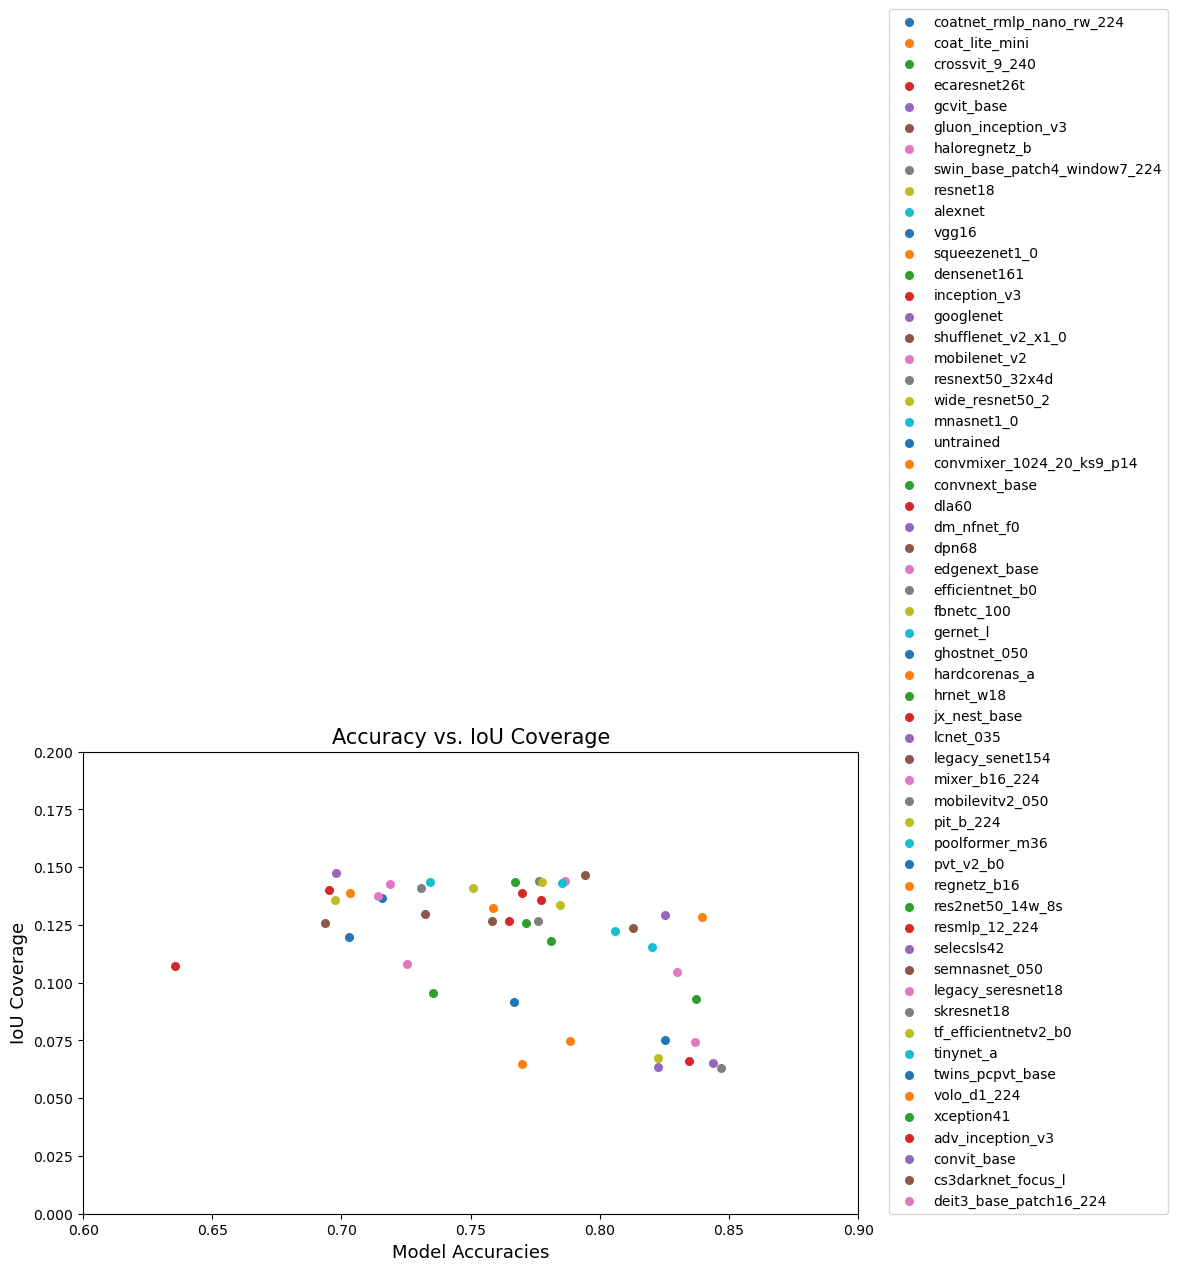

In [23]:
#Create a scatterplot plotting average Shared Interest score against on the y-axis and average accuracy on the x-axis for each model. 

plt.figure(figsize=(10,6))
for model_name in model_accuracy: 
    x = model_accuracy[model_name]
    y = model_scores[model_name]['iou_coverage']
    plt.scatter(x, y, s=30, label=model_name)
    
plt.title("Accuracy vs. IoU Coverage", fontdict={'fontsize': 15})
plt.xlabel("Model Accuracies", fontdict={'fontsize': 13})
plt.ylabel("IoU Coverage", fontdict={'fontsize': 13})
plt.legend(loc=(1.04, 0))
plt.xlim([0.6,0.9])
plt.ylim([0.0,0.2])

(0.0, 0.2)

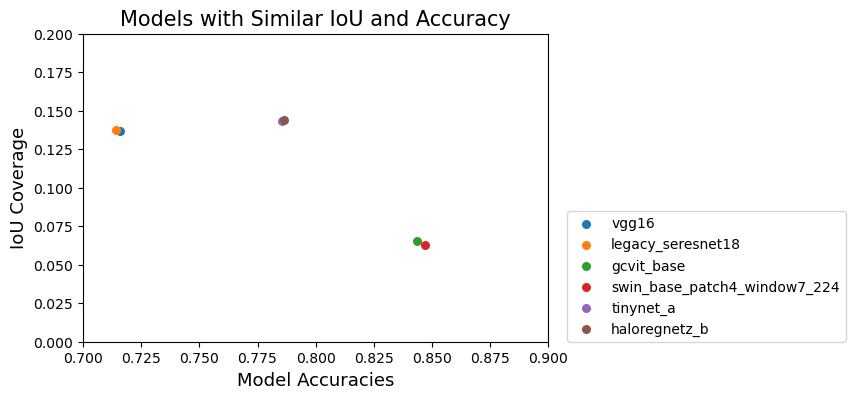

In [80]:
similar = ["vgg16", "legacy_seresnet18", "gcvit_base", "swin_base_patch4_window7_224",
           "tinynet_a", "haloregnetz_b"]

plt.figure(figsize=(6,4))
for model_name in similar: 
    x = model_accuracy[model_name]
    y = model_scores[model_name]['iou_coverage']
    plt.scatter(x, y, s=30, label=model_name)
    
plt.title("Models with Similar IoU and Accuracy", fontdict={'fontsize': 15})
plt.xlabel("Model Accuracies", fontdict={'fontsize': 13})
plt.ylabel("IoU Coverage", fontdict={'fontsize': 13})
plt.legend(loc=(1.04, 0))
plt.xlim([0.7,0.9])
plt.ylim([0.0,0.2])

In [79]:
# one pair with similar accuracy and IoU
print(model_scores["vgg16"]['iou_coverage'])
print(model_scores["legacy_seresnet18"]['iou_coverage'])
print(model_accuracy["vgg16"])
print(model_accuracy["legacy_seresnet18"])

0.13684707958783934
0.13760770261454416
0.715790946896993
0.7140744884910486


In [81]:
# second pair with similar accuracy and IoU
print(model_scores["gcvit_base"]['iou_coverage'])
print(model_scores["swin_base_patch4_window7_224"]['iou_coverage'])
print(model_accuracy["gcvit_base"])
print(model_accuracy["swin_base_patch4_window7_224"])

0.06540237506525054
0.06309218394751819
0.8437699808184144
0.8469868925831202


In [82]:
# third pair with similar accuracy and IoU
print(model_scores["tinynet_a"]['iou_coverage'])
print(model_scores["haloregnetz_b"]['iou_coverage'])
print(model_accuracy["tinynet_a"])
print(model_accuracy["haloregnetz_b"])

0.14305599476600525
0.14422232548089312
0.785465952685422
0.7863650895140665


(0.0, 0.2)

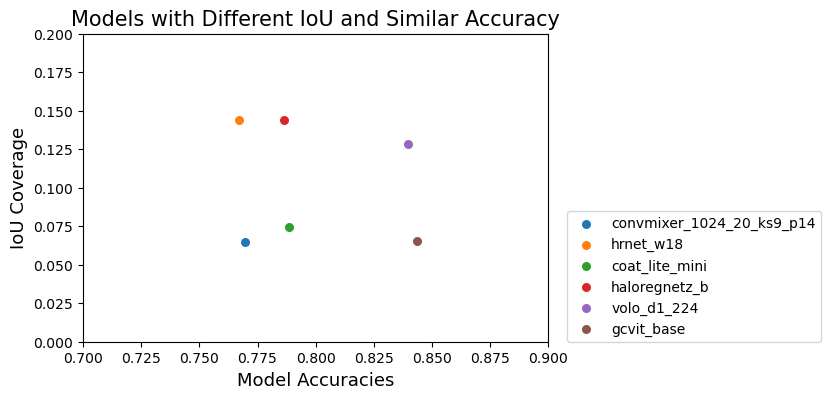

In [78]:
different = ["convmixer_1024_20_ks9_p14", "hrnet_w18", "coat_lite_mini", "haloregnetz_b",
            "volo_d1_224", "gcvit_base"]

plt.figure(figsize=(6,4))
for model_name in different: 
    x = model_accuracy[model_name]
    y = model_scores[model_name]['iou_coverage']
    plt.scatter(x, y, s=30, label=model_name)
    
plt.title("Models with Different IoU and Similar Accuracy", fontdict={'fontsize': 15})
plt.xlabel("Model Accuracies", fontdict={'fontsize': 13})
plt.ylabel("IoU Coverage", fontdict={'fontsize': 13})
plt.legend(loc=(1.04, 0))
plt.xlim([0.7,0.9])
plt.ylim([0.0,0.2])

In [20]:
# one pair with similar accuracy and vastly different IoU
print(model_scores["convmixer_1024_20_ks9_p14"]['iou_coverage'])
print(model_scores["hrnet_w18"]['iou_coverage'])
print(model_accuracy["convmixer_1024_20_ks9_p14"])
print(model_accuracy["hrnet_w18"])

0.06485664346117777
0.14380720884088152
0.7697410485933504
0.7671835038363172


In [45]:
# second pair with similar accuracy and vastly different IoU
#"volo_d1_224", "jx_nest_base", "gcvit_base"
print(model_scores["volo_d1_224"]['iou_coverage'])
print(model_scores["gcvit_base"]['iou_coverage'])
print(model_accuracy["volo_d1_224"])
print(model_accuracy["gcvit_base"])

0.1282507673259764
0.06540237506525054
0.8397338554987213
0.8437699808184144


In [19]:
# third pair with similar accuracy and vastly different IoU
print(model_scores["coat_lite_mini"]['iou_coverage'])
print(model_scores["haloregnetz_b"]['iou_coverage'])
print(model_accuracy["coat_lite_mini"])
print(model_accuracy["haloregnetz_b"])

0.07466045456209751
0.14422232548089312
0.7884830562659847
0.7863650895140665


(0.0, 1.0)

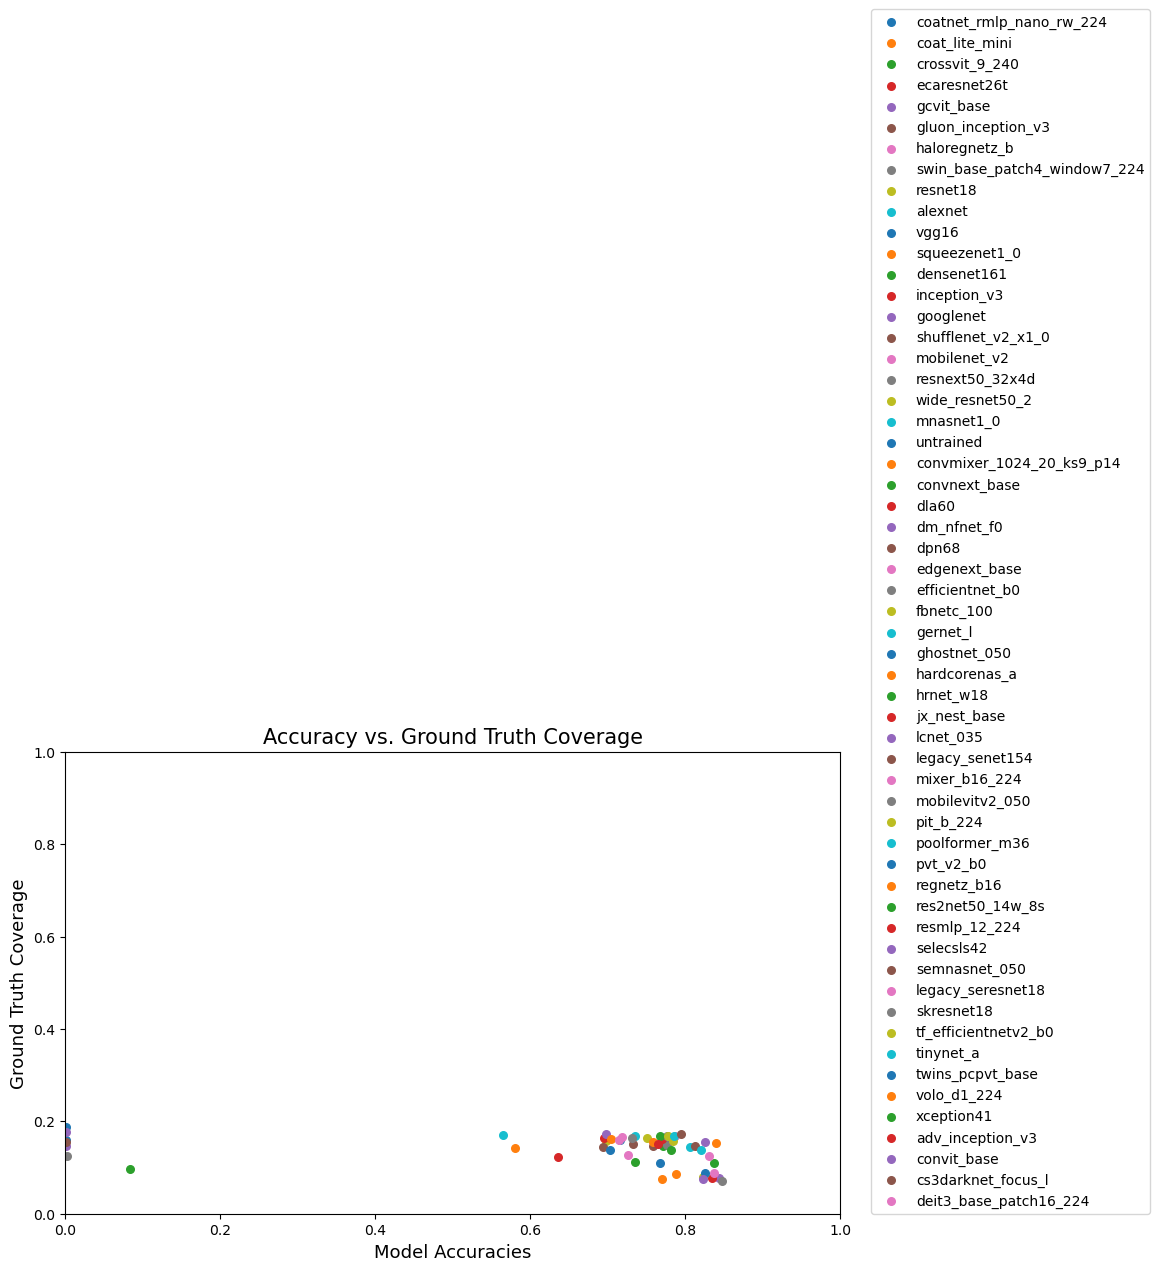

In [88]:
plt.figure(figsize=(10,6))
for model_name in model_accuracy: 
    x = model_accuracy[model_name]
    y = model_scores[model_name]['ground_truth_coverage']
    plt.scatter(x, y, s=30, label=model_name)
    
plt.title("Accuracy vs. Ground Truth Coverage", fontdict={'fontsize': 15})
plt.xlabel("Model Accuracies", fontdict={'fontsize': 13})
plt.ylabel("Ground Truth Coverage", fontdict={'fontsize': 13})
plt.legend(loc=(1.04, 0))
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

(0.0, 1.0)

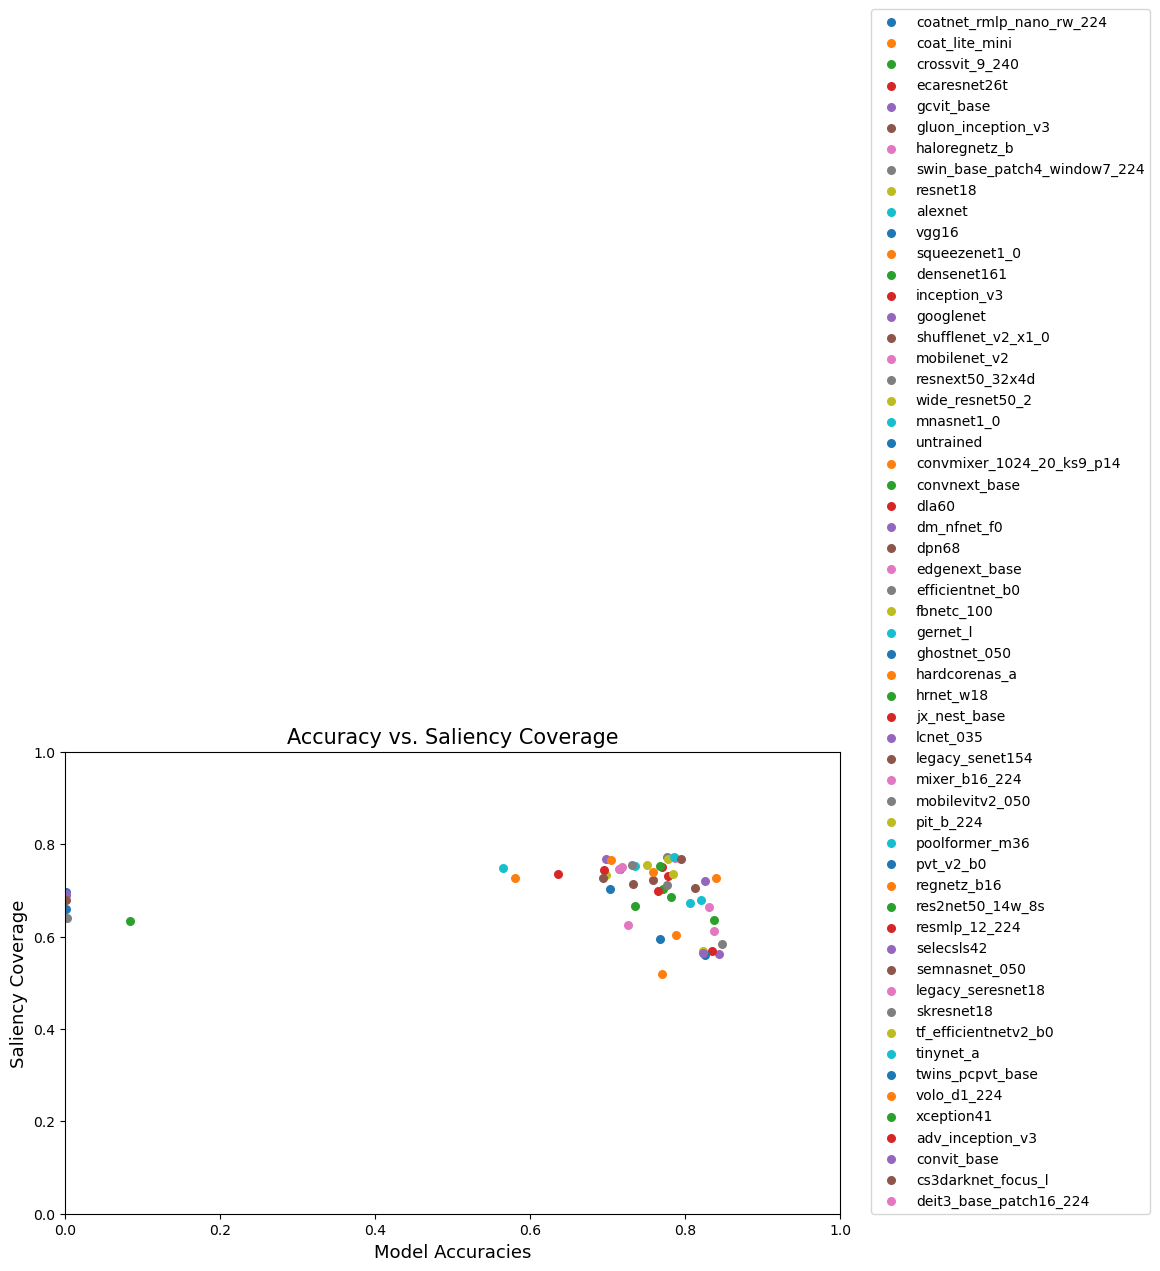

In [89]:
plt.figure(figsize=(10,6))
for model_name in model_accuracy: 
    x = model_accuracy[model_name]
    y = model_scores[model_name]['saliency_coverage']
    plt.scatter(x, y, s=30, label=model_name)
    
plt.title("Accuracy vs. Saliency Coverage", fontdict={'fontsize': 15})
plt.xlabel("Model Accuracies", fontdict={'fontsize': 13})
plt.ylabel("Saliency Coverage", fontdict={'fontsize': 13})
plt.legend(loc=(1.04, 0))
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

In [ ]:
# now saving saliency maps
compare_models = ["convmixer_1024_20_ks9_p14", "hrnet_w18", "coat_lite_mini", "haloregnetz_b", "volo_d1_224", "gcvit_base",
                  "vgg16", "legacy_seresnet18", "swin_base_patch4_window7_224", "tinynet_a"]

torch.cuda.empty_cache()
for model_name in compare_models:
    print (model_name)
    current_path = os.path.abspath(os.getcwd()) + "/" + model_name + "/"
    model = timm.create_model(model_name, pretrained=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    try:
        accuracy, saliency_masks, shared_interest_scores, predictions = run(model, dataloader, VanillaGradients(model))
        with open(os.path.join(current_path, "saliency_masks.pickle"), "wb") as handle:
            pickle.dump(saliency_masks, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        with open(os.path.join(current_path, "predictions.pickle"), "wb") as handle:
            pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    except:
        print ("error while: " + model_name)
    torch.cuda.empty_cache()

convmixer_1024_20_ks9_p14


 30%|█████████████████████████████▍                                                                    | 235/782 [04:10<09:23,  1.03s/it]